In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras


# Parameters
L = 2.0             # Length of the beam [m]
EI = 2e6            # Flexural rigidity [Nm^2]
Q = 1000.0 # Uniform load [N/m]
P = 1000.0           # Point load [N]
a = L / 6            # Load applied at midspan
hinge_loc = 2 * L / 5.

colloc_width = L / 4.
colloc_density = 20

dl = 0.01 * L

act = 'swish'
Noise = False
USE_COLLOC = False
Use_Max = False 
CAP = True
cap_val_min = 1e-4
cap_val_max = 1e4

In [3]:

x_full = np.linspace(0, L, 200)
x_full_norm = x_full/ L

def w(x, L, Q):
 w = (Q * x**2 * (6*L**2 - 4*L*x + x**2)) / (24 * EI)
 return w

def w_point_load(x, L, P, a):
    w = np.zeros_like(x)
    mask1 = x <= a
    mask2 = x > a
    w[mask1] = (P * x[mask1]**2 * (3*a - x[mask1])) / (6 * EI)
    w[mask2] = (P * a**2 * (3*x[mask2] - a)) / (6 * EI)
    return w

def w_udl_hinge(x, hinge_loc, L, Q):
  x_left, x_right = x[x <= hinge_loc], x[hinge_loc < x]
  return np.concatenate([w(x_left, hinge_loc, Q), w(x_right - x_right[0], L - hinge_loc, Q)[::-1]])

def w_udl_hinge(x, hinge_loc, L, q):
    x = np.asarray(x)
    w_out = np.zeros_like(x, dtype=float)

    left  = x <= hinge_loc          # choose one side to hold the equality consistently
    right = ~left

    # Left half: cantilever fixed at x=0, free at x=hinge_loc
    s_left = x[left]                      # distance from fixed end
    w_out[left] = w(s_left, hinge_loc, q)

    # Right half: mirror—cantilever fixed at x=L, free at x=hinge_loc
    s_right = L - x[right]                # distance from right fixed end
    w_out[right] = w(s_right, L - hinge_loc, q)

    return w_out
  
def get_collocation_points(x_sensors, pred_hinge_loc, colloc_width, colloc_density):

    hinge_start = pred_hinge_loc - colloc_width / 2.
    hinge_end = pred_hinge_loc + colloc_width / 2.
    
    dense_sensors = tf.linspace(hinge_start, hinge_end, colloc_density)
    dense_sensors = tf.cast(tf.reshape(dense_sensors, (-1, 1)), dtype=tf.float32)
    x_colloc = tf.concat((x_sensors, dense_sensors), axis=0)
    
    return tf.sort(x_colloc, axis=0)

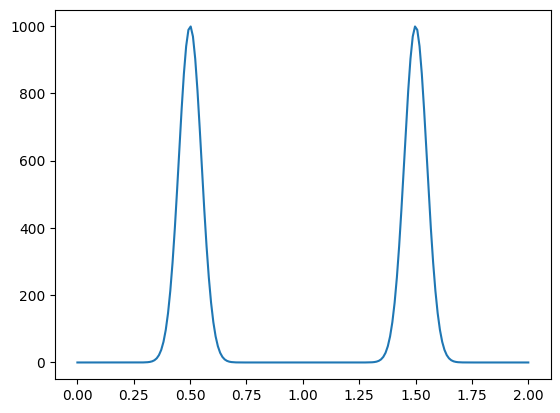

In [4]:
def gaussian_prop(x, x_p, P, sigma=0.01):
     # scale height so area = total_force
    return  P * np.exp(-0.5 * ((x - x_p) / sigma) ** 2)

l = gaussian_prop(x_full, L / 4, P, sigma=0.05) + gaussian_prop(x_full, 3 * L / 4, P, sigma=0.05)
plt.plot(x_full, l)

In [5]:
def get_shear(a, b, L, P, Q):
    t1 = a**2 * (b / 2 - a / 6) * P
    t2 = Q / 8 * ((L - b)**4 - b**4)
    t3 = 1 / 3 * ((L - b)**3 + b**3)
    V = (t1 - t2) / t3
    return V
shear = get_shear(a, hinge_loc, L, P, Q)

shear


-227.3148148148148

([<matplotlib.lines.Line2D at 0x30304a540>],
 Text(0.5, 1.0, 'Deflection w(x)'),
 Text(0.5, 0, 'x (m)'),
 Text(0, 0.5, 'w (m)'))

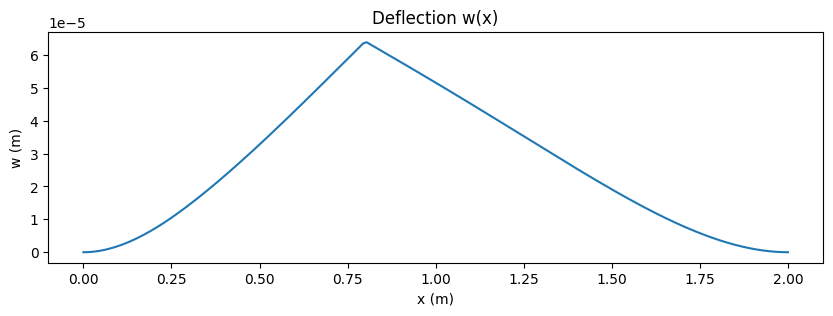

In [6]:
x_left = x_full[x_full <= hinge_loc]
w_left = w(x_left, hinge_loc, Q) + w_point_load(x_left, hinge_loc, P, a) + w_point_load(x_left, hinge_loc, -shear, hinge_loc)
x_right = x_full[x_full > hinge_loc]
w_right = w(L - x_right, L - hinge_loc, Q) + w_point_load(L - x_right, L - hinge_loc, shear, L - hinge_loc)

plt.figure(figsize=(10, 3))
plt.plot(x_full, np.concatenate([w_left, w_right])), plt.title("Deflection w(x)"), plt.xlabel("x (m)"), plt.ylabel("w (m)")

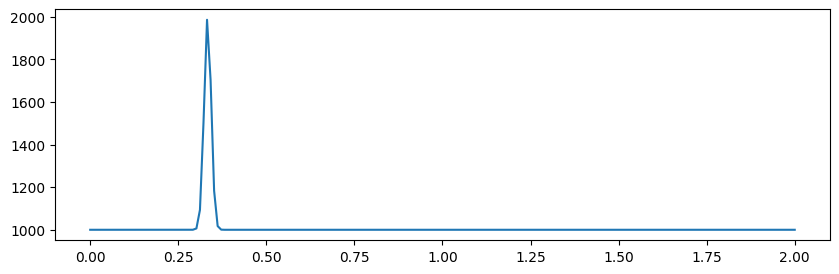

In [7]:
q_true = np.ones_like(x_full) * Q + gaussian_prop(x_full, a, P)
plt.figure(figsize=(10, 3)) 
plt.plot(x_full, q_true)

In [65]:
def norm_sig(x_norm, k):
    return 2 * (tf.sigmoid(k*x_norm) - 0.5)

def sigmoid_scale(phys_lb, sigmoid_amplitude, characteristic_length_scacle):
    characteristic_amplitude = norm_sig(characteristic_length_scacle, 1)
    sigmoid_scale = characteristic_length_scacle / (1 - characteristic_amplitude * sigmoid_amplitude / phys_lb)
    return sigmoid_scale

tf.Tensor(0.90514827, shape=(), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=13.198600769042969>

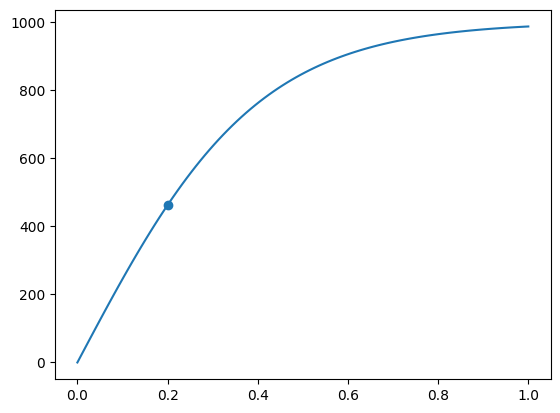

In [102]:
x_norm = tf.linspace(0, 1, 100)
fexp = tf.exp(5 * x_norm) 
flog = 1e3 * tf.math.log(x_norm + 1)
fsoft = tf.math.softplus(x_norm)

A = 1e3
k = 5
lc = 1 / k
print(norm_sig(3/10, 10))

fsig = A * norm_sig(x_norm, k)

plt.plot(x_norm, fsig)
plt.scatter(lc, A * norm_sig(lc, k))

phys_min = A * norm_sig(lc, k) / (1 - lc)
phys_min
sigmoid_scale(1e9 * (5e-3)**4, 0.1, 5.)
sigmoid_scale(0.5, 1., 1.)

In [105]:
1e8 * (5e-3)**4

0.0625